## やりたいこと
- 予測アプリ
    - 緯度・軽度を分割する。
    - 分割したエリアに乗車・降車ポイントをgooglemap上にプロット
    - 分割したエリアの当日における15分単位の乗車確立を図示する。(ディープラーニングで2値問題の確立はだせる）
        - 何をデータに食わせるか？（1年間の全データ？15分刻みのデータ？）
        - 分割したエリアの当日における15分単位の乗車確率を図示する。(ディープラーニングで2値問題の確立はだせる?）
           => 該当エリアの乗車実績数/全エリアの乗車実績数　でもだせるが・・・
    - 分割したエリアで乗車した場合の予測乗車時間を図示する。(ディープラーニングで回帰予測はできるの？）
    - 分割したエリアで乗車した場合の予測進路を8種類で図示する。（乗車、降車の教師データから方向はだせて、ディープラーニングで予測できる）

- クラスタリング
    - 優良ドライバーと新人ドライバーの比較ではなく、顧客を分析した方が良いか？
        - どう分類する？

## データ考察

In [1]:
# Google Map上にプロットするライブラリ
# !pip install gmplot

In [2]:
import pandas as pd 
import numpy as np
import re
import copy
from datetime import datetime as dt
from gmplot import gmplot

from matplotlib import pyplot as plt
import seaborn as sns

# warningの抑止
import warnings
warnings.filterwarnings('ignore')

# メモリ解放
import gc

In [3]:
pd.set_option("display.max_columns", 30)

# データを読み込む
df = pd.read_csv("data/edit_train.csv")

df.head()

,TIMESTAMP,year,month,day,weekday,hour,minute,second,TAXI_ID,TRIP_ID,holiday,riding_time,distance,start_x,start_y,end_x,end_y,DAY_TYPE,CALL_TYPE,ORIGIN_STAND,ORIGIN_CALL,MISSING_DATA
0,1372636853,2013,7,1,mon,0,0,53,20000380,1372636853620000380,o,375,2.395003,-8.610291,41.140746,-8.605890,41.145345,A,C,NaN,NaN,False
1,1372636854,2013,7,1,mon,0,0,54,20000520,1372636854620000520,o,645,10.114430,-8.574678,41.151951,-8.607996,41.142915,A,C,NaN,NaN,False
2,1372636858,2013,7,1,mon,0,0,58,20000589,1372636858620000589,o,345,3.186095,-8.618643,41.141412,-8.630838,41.154489,A,C,NaN,NaN,False
3,1372636875,2013,7,1,mon,0,1,15,20000233,1372636875620000233,o,330,2.549688,-8.619894,41.148009,-8.609490,41.157351,A,C,NaN,NaN,False
4,1372636896,2013,7,1,mon,0,1,36,20000360,1372636896620000360,o,645,10.080812,-8.617599,41.146137,-8.636625,41.169141,A,C,NaN,NaN,False


In [4]:
# 降車ポイントが不明なデータを削除
df.drop(df[df["MISSING_DATA"] != False].index.values, inplace=True)
df[df["MISSING_DATA"] != False].shape[0]

0

In [5]:
df.shape

(1674152, 22)

In [6]:
df.describe()[[
    "riding_time", "distance", "start_x", "start_y", "end_x", "end_y"
]]

,riding_time,distance,start_x,start_y,end_x,end_y
count,1.674152e+06,1.674152e+06,1.674152e+06,1.674152e+06,1.674152e+06,1.674152e+06
mean,7.470452e+02,6.603551e+00,-8.617299e+00,4.115702e+01,-8.620153e+00,4.116235e+01
std,6.838430e+02,8.913975e+00,2.783447e-02,2.084918e-02,3.786713e-02,3.612992e-02
min,3.000000e+01,0.000000e+00,-1.215453e+01,3.718483e+01,-1.347646e+01,3.731378e+01
25%,4.350000e+02,2.887005e+00,-8.628822e+00,4.114785e+01,-8.640756e+00,4.114869e+01
50%,6.300000e+02,4.752176e+00,-8.612739e+00,4.115434e+01,-8.615223e+00,4.115782e+01
75%,8.850000e+02,7.916631e+00,-8.603748e+00,4.116317e+01,-8.602776e+00,4.117081e+01
max,5.821500e+04,1.609067e+03,-4.816116e+00,5.103712e+01,-5.793111e+00,4.435162e+01


In [7]:
# 乗車時間最大、乗車距離最大
print(5.821500e+04 / 60 / 60, "時間")
print(1.609067e+03, "km")

16.170833333333334 時間
1609.067 km


In [8]:
# ORIGIN_STAND != None なのでタクシースタンドからの乗車(CALL_TYPE =B)なので旅行客と思われる。恐らく、DAY_TYPEは誤り
df[ df["distance"] > 1.60e+03]

,TIMESTAMP,year,month,day,weekday,hour,minute,second,TAXI_ID,TRIP_ID,holiday,riding_time,distance,start_x,start_y,end_x,end_y,DAY_TYPE,CALL_TYPE,ORIGIN_STAND,ORIGIN_CALL,MISSING_DATA
1238238,1396444676,2014,4,2,wed,13,17,56,20000386,1396444676620000386,o,510,1609.066766,-8.630694,41.154858,-8.644806,41.158917,A,B,12.0,NaN,False


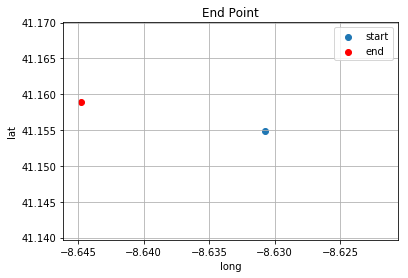

In [9]:
plt.scatter(-8.630694, 41.154858, label="start")
plt.scatter(-8.644806, 41.158917, color="r", label="end")
plt.title("Start - End Point")
plt.title("End Point")
plt.xlabel("long")
plt.ylabel("lat")
plt.legend()
plt.grid()

In [10]:
# 経度における 最大 - 最小 距離
(-4.816116e+00 - -1.215453e+01) * 111

814.563954

距離が長すぎるので、-8.65e+00 - -8.60e+00 までに絞る	

In [11]:
(-8.650000e+00 - -8.660000e+00)* 111

1.1099999999999763

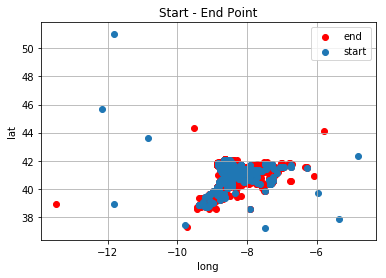

In [12]:
plt.scatter(df["end_x"], df["end_y"], color="r", label="end")
plt.scatter(df["start_x"], df["start_y"], label="start")
plt.title("Start - End Point")
plt.xlabel("long")
plt.ylabel("lat")
plt.legend()
plt.grid()

## 緯度、経度がおかしいデータを削除

[ポルト - wiki](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%83%AB%E3%83%88)

[地理的座標と地図 ポルト - ポルトガル共和国](https://www.horlogeparlante.com/%E5%9C%B0%E7%90%86%E5%BA%A7%E6%A8%99-2735943.html)

[ポルト - Google Map](https://www.google.co.jp/maps/place/41%C2%B008'58.0%22N+8%C2%B036'39.0%22W/@41.1361111,-8.7411266,11.3z/data=!4m5!3m4!1s0x0:0x0!8m2!3d41.1494444!4d-8.6108333?hl=ja)

[ポルト - 温度](https://tentsuki.jp/information/portugal/1430/)

[ポルトにおける平均的な気候](https://ja.weatherspark.com/y/32397/%E3%83%9D%E3%83%AB%E3%83%88%E3%80%81%E3%83%9D%E3%83%AB%E3%83%88%E3%82%AC%E3%83%AB%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E5%B9%B4%E9%96%93%E3%81%AE%E5%B9%B3%E5%9D%87%E7%9A%84%E3%81%AA%E6%B0%97%E5%80%99)

[タクシー料金の仕組み](https://trafficnews.jp/post/65196)

●公園：41.1579,-8.6291
市庁舎：41.149444, -8.610833

In [13]:
# ポルト の面積は 41km*2
# 経度が-9.5以下は海とみなす
print(df[df["start_x"] < -9.5].shape, df[df["end_x"] < -9.5].shape)

# 経度が42.0以上は国外とみなす
print(df[df["start_y"] > 42.0].shape, df[df["end_y"] > 42.0].shape)

(5, 22) (3, 22)
(10, 22) (78, 22)


In [14]:
# df.query("-9.5 < start_x < -6.5 and -9.5 < end_x < -6.5 and start_y < 42.0 and end_y < 42.0", inplace=True)
# df.shape

## CALL_TYPE による乗降ポイントのプロット
- タクシー会社からの配車：A 
- タクシー乗り場：B 
- 流し：C 

In [15]:
df_call_type_a = df[df["CALL_TYPE"] == "A"]
df_call_type_b = df[df["CALL_TYPE"] == "B"]
df_call_type_c = df[df["CALL_TYPE"] == "C"]

In [16]:
df_call_type_a.head()

,TIMESTAMP,year,month,day,weekday,hour,minute,second,TAXI_ID,TRIP_ID,holiday,riding_time,distance,start_x,start_y,end_x,end_y,DAY_TYPE,CALL_TYPE,ORIGIN_STAND,ORIGIN_CALL,MISSING_DATA
14,1372637254,2013,7,1,mon,0,7,34,20000657,1372637254620000657,o,645,8.372939,-8.660646,41.168574,-8.601894,41.181813,A,A,NaN,39233.0,False
18,1372637343,2013,7,1,mon,0,9,3,20000571,1372637343620000571,o,480,6.822088,-8.618868,41.155101,-8.575065,41.162265,A,A,NaN,31508.0,False
21,1372637397,2013,7,1,mon,0,9,57,20000190,1372637397620000190,o,840,11.237709,-8.620938,41.150034,-8.559153,41.177214,A,A,NaN,2002.0,False
26,1372637658,2013,7,1,mon,0,14,18,20000596,1372637658620000596,o,390,3.307791,-8.665686,41.170626,-8.654337,41.187816,A,A,NaN,22864.0,False
37,1372638035,2013,7,1,mon,0,20,35,20000337,1372638035620000337,o,345,3.416876,-8.688825,41.167323,-8.673750,41.149665,A,A,NaN,39353.0,False


In [17]:
print(df["start_x"].max(),df["start_x"].min())
print(df["end_x"].max(),df["end_x"].min())

print(df["start_y"].max(),df["start_y"].min())
print(df["end_y"].max(),df["end_y"].min())

-4.816116 -12.154527
-5.793111 -13.476465
51.037119 37.184832
44.351622 37.313784000000005


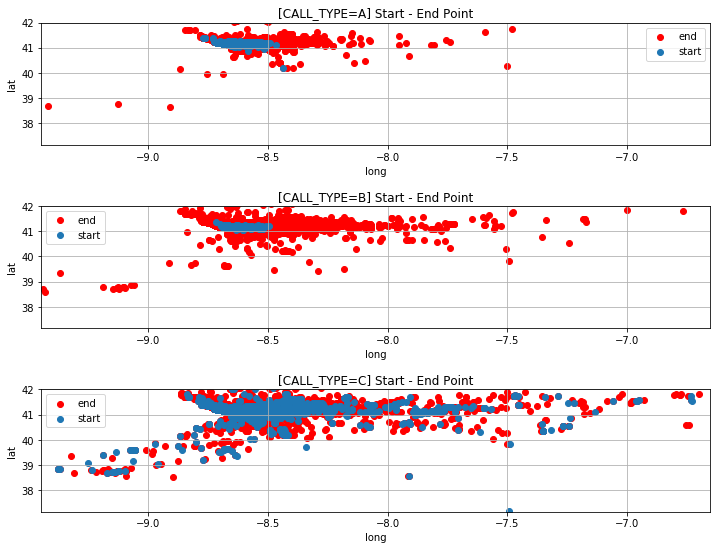

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(12.0, 9.0))

plt.subplots_adjust(hspace=0.5)

# CALL_TYPE= A
ax[0].scatter(df_call_type_a["end_x"], df_call_type_a["end_y"], color="r", label="end")
ax[0].scatter(df_call_type_a["start_x"], df_call_type_a["start_y"], label="start")
ax[0].set_title("[CALL_TYPE=A] Start - End Point")
ax[0].set_xlabel("long")
ax[0].set_ylabel("lat")
ax[0].set_xlim(-9.45, -6.65)
ax[0].set_ylim(37.15, 42.0)
ax[0].legend()
ax[0].grid()

# CALL_TYPE= B
ax[1].scatter(df_call_type_b["end_x"], df_call_type_b["end_y"], color="r", label="end")
ax[1].scatter(df_call_type_b["start_x"], df_call_type_b["start_y"], label="start")
ax[1].set_title("[CALL_TYPE=B] Start - End Point")
ax[1].set_xlabel("long")
ax[1].set_ylabel("lat")
ax[1].set_xlim(-9.45, -6.65)
ax[1].set_ylim(37.15, 42.0)
ax[1].legend()
ax[1].grid()

# CALL_TYPE= C
ax[2].scatter(df_call_type_c["end_x"], df_call_type_c["end_y"], color="r", label="end")
ax[2].scatter(df_call_type_c["start_x"], df_call_type_c["start_y"], label="start")
ax[2].set_title("[CALL_TYPE=C] Start - End Point")
ax[2].set_xlabel("long")
ax[2].set_ylabel("lat")
ax[2].set_xlim(-9.45, -6.65)
ax[2].set_ylim(37.15, 42.0)
ax[2].legend()
ax[2].grid()

plt.show()

- 基本的に左から右に行きたい人が多い。
- 流しの場合は、放射線?


### CALL_TYPE毎に考察

In [19]:
df_call_type_a.shape, df_call_type_b.shape, df_call_type_c.shape

((362716, 22), (808889, 22), (502547, 22))

#### 配車センター

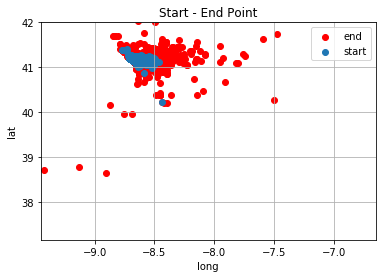

In [20]:
# CALL_TYPE= A（センター）
plt.scatter(df_call_type_a["end_x"], df_call_type_a["end_y"], color="r", label="end")
plt.scatter(df_call_type_a["start_x"], df_call_type_a["start_y"], label="start")
plt.title("Start - End Point")
plt.xlabel("long")
plt.ylabel("lat")
plt.xlim(-9.45, -6.65)
plt.ylim(37.15, 42.0)
plt.legend()
plt.grid()

#### スタンド

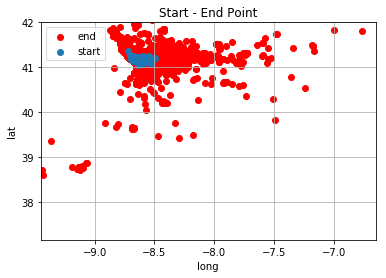

In [21]:
# CALL_TYPE= B（スタンド）
plt.scatter(df_call_type_b["end_x"], df_call_type_b["end_y"], color="r", label="end")
plt.scatter(df_call_type_b["start_x"], df_call_type_b["start_y"], label="start")
plt.title("Start - End Point")
plt.xlabel("long")
plt.ylabel("lat")
plt.xlim(-9.45, -6.65)
plt.ylim(37.15, 42.0)
plt.legend()
plt.grid()

#### 流し

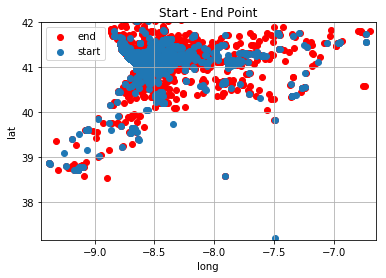

In [22]:
plt.scatter(df_call_type_c["end_x"], df_call_type_c["end_y"], color="r", label="end")
plt.scatter(df_call_type_c["start_x"], df_call_type_c["start_y"], label="start")
plt.title("Start - End Point")
plt.xlabel("long")
plt.ylabel("lat")
plt.xlim(-9.45, -6.65)
plt.ylim(37.15, 42.0)
plt.legend()
plt.grid()

### 月、曜日ごと、祝日ごとにプロット

### 月でプロット

#### 全体

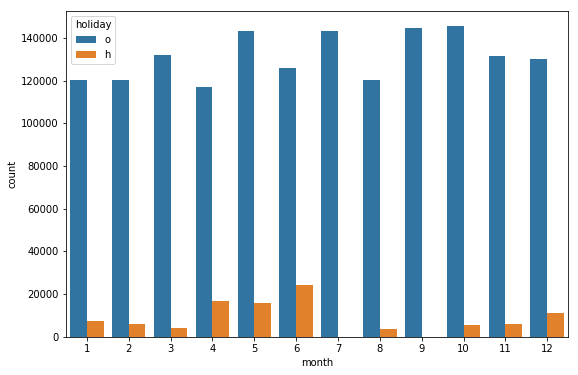

In [23]:
plt.figure(figsize=(9.0, 6.0))
sns.countplot(x="month", hue="holiday", data=df)

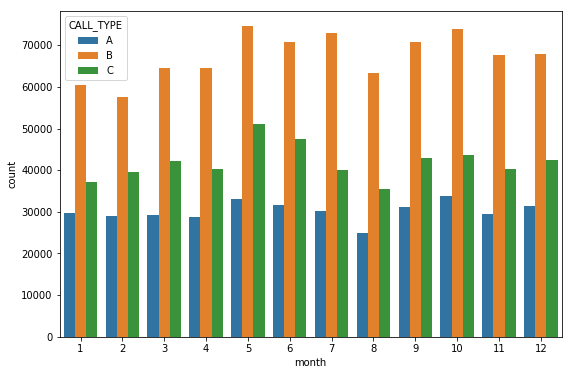

In [24]:
plt.figure(figsize=(9.0, 6.0))
# plt.legend(('A','B','C')) # 凡例
sns.countplot(x="month", hue="CALL_TYPE", hue_order=["A", "B", "C"], data=df)

#### 配車センターの場合

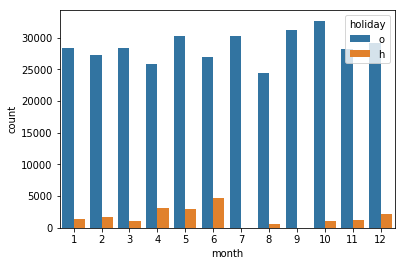

In [25]:
sns.countplot(x="month", hue="holiday", data=df_call_type_a)

#### スタンドの場合

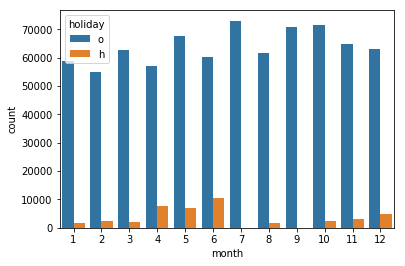

In [26]:
sns.countplot(x="month", hue="holiday", data=df_call_type_b)

#### 流しの場合

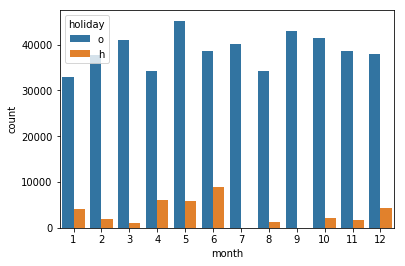

In [27]:
sns.countplot(x="month", hue="holiday",data=df_call_type_c)

月間の最大さは14011万件くらい（例：流しの5月と1月）    
但し、14011/442 = 31.7件、　これは、日当たり　31.7/31 = 1.05件しか差がない為、多くはない。    
因みに、流し-月別の乗車距離の平均は1月と5月では0.6km位異なる。

In [28]:
type(df_call_type_c[df_call_type_c["month"] == 1])

pandas.core.frame.DataFrame

In [29]:
display(df_call_type_c[df_call_type_c["month"] == 5].shape[0] -
        df_call_type_c[df_call_type_c["month"] == 1].shape[0])

# sns.countplot(x="distance", hue="holiday",data=df_call_type_c)
display(df_call_type_c[df_call_type_c["month"] == 1].describe()["distance"].loc["mean"])
display(df_call_type_c[df_call_type_c["month"] == 5].describe()["distance"].loc["mean"])

14011

7.502880559581519

8.15289458590644

#### 考察（月）
- 最小利用者数は、配車センターは10月・８月、スタンドは７月・２月、流しは５月・１月。
- 配車センター、スタンドも流しも分布に決定的な差異はない。
- 5月の利用が多い
- 祝日の利用は4,5,6月が多い（5月は観光のベストシーズンらしい）

### 曜日でプロット

#### 全体

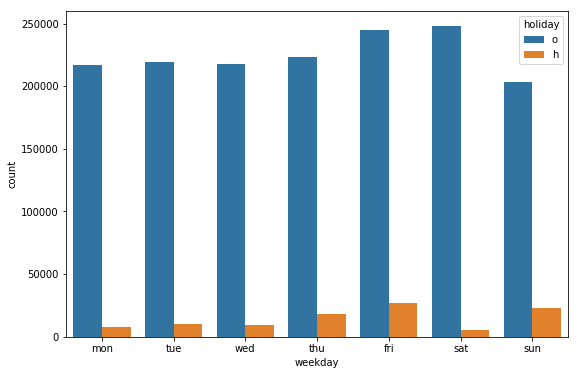

In [30]:
plt.figure(figsize=(9.0, 6.0))
sns.countplot(x="weekday", hue="holiday", data=df)

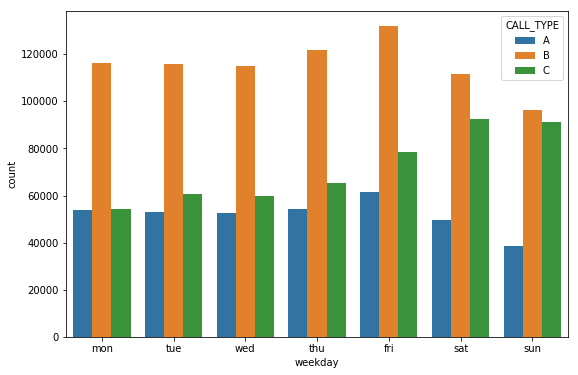

In [31]:
plt.figure(figsize=(9.0, 6.0))
sns.countplot(x="weekday", hue="CALL_TYPE", hue_order=["A", "B", "C"], data=df)

配車センター、スタンドは週末の利用が少ないが、流しは平日が少なく、週末が多い事がわかる。

#### 配車センターの場合

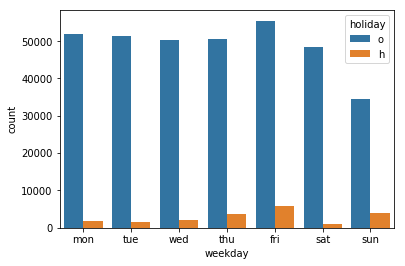

In [32]:
sns.countplot(x="weekday", hue="holiday", data=df_call_type_a)

#### スタンドの場合

In [33]:
# 祝日（土日含む）
df_call_type_b[ (df_call_type_b["holiday"] == "h")].shape

(43205, 22)

In [34]:
# 祝日でない日曜日
df_call_type_b[(df_call_type_b["weekday"] == "sun") & (df_call_type_b["holiday"] != "h")].shape

(86651, 22)

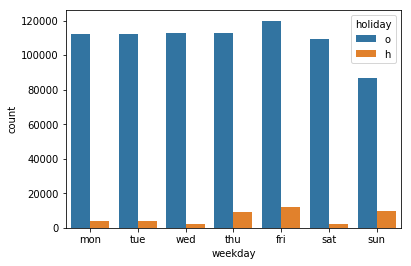

In [35]:
sns.countplot(x="weekday", hue="holiday", data=df_call_type_b)

#### 流しの場合

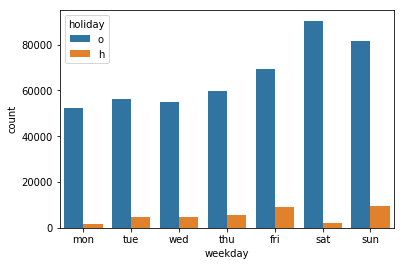

In [36]:
sns.countplot(x="weekday", hue="holiday", data=df_call_type_c)

In [37]:
40000 / (365 / 7) / 442

1.7355730490299384

傾向として、金曜日の利用が多く、日曜は少ない（祝日の場合はスタンドと同等の需要ある）

#### 考察
- スタンドの場合
    - 平日に利用される事が多く、日曜は少ない（流しと同程度）
- 流しの場合
    - 平日は利用が少ない（潜在的チャンスを逃している可能性あり）される事が多く、土日が多い。
- 金曜日の需要が高い
- 土曜の祝日は需要が低い　
- 日曜の祝日は需要がある

### 時間でプロット

#### 全体

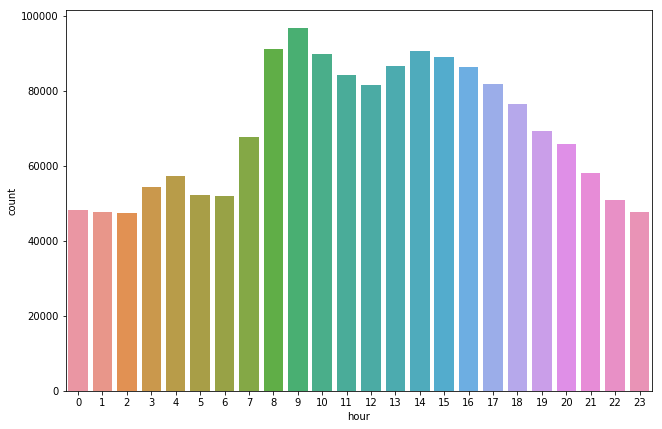

In [77]:
plt.figure(figsize=(10.5, 7.0))

sns.countplot(x="hour", data=df)

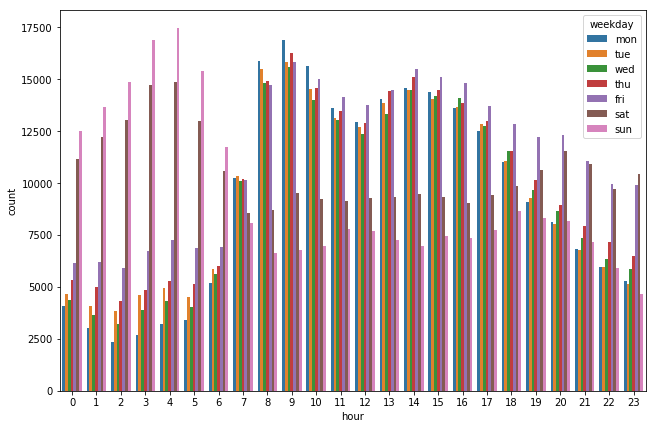

In [38]:
plt.figure(figsize=(10.5, 7.0))

sns.countplot(x="hour", hue="weekday", data=df)

#### 配車センターの場合

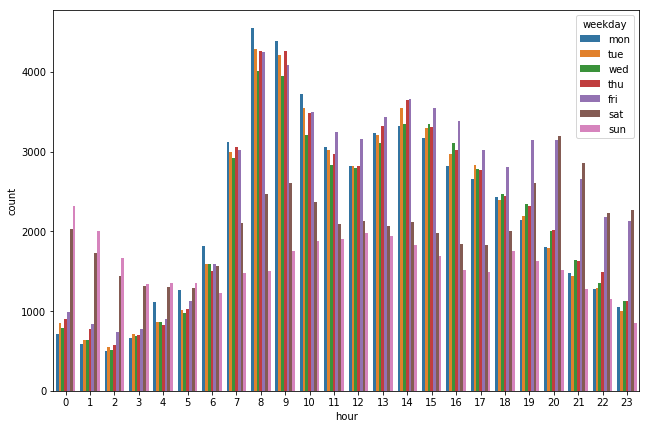

In [39]:
plt.figure(figsize=(10.5, 7.0))

sns.countplot(x="hour", hue="weekday", data=df_call_type_a)

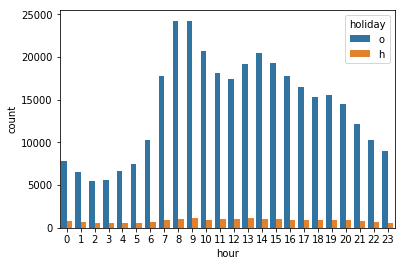

In [40]:
sns.countplot(x="hour", hue="holiday", data=df_call_type_a)

#### スタンドの場合

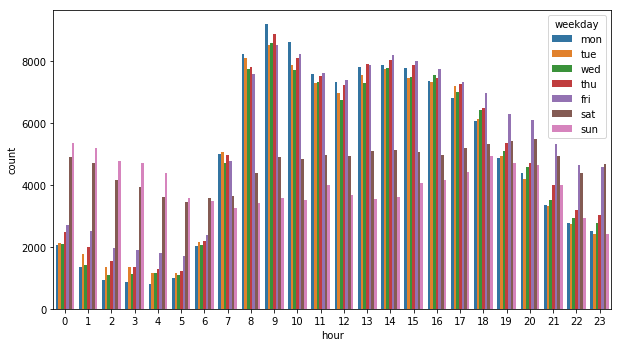

In [41]:
plt.figure(figsize=(10.0, 5.5))

sns.countplot(x="hour", hue="weekday", data=df_call_type_b)

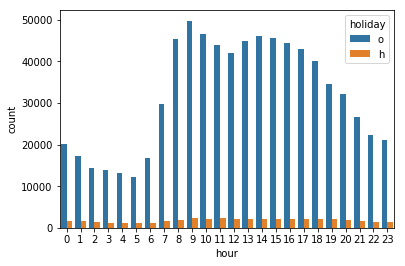

In [42]:
sns.countplot(x="hour", hue="holiday", data=df_call_type_b)

#### 流しの場合

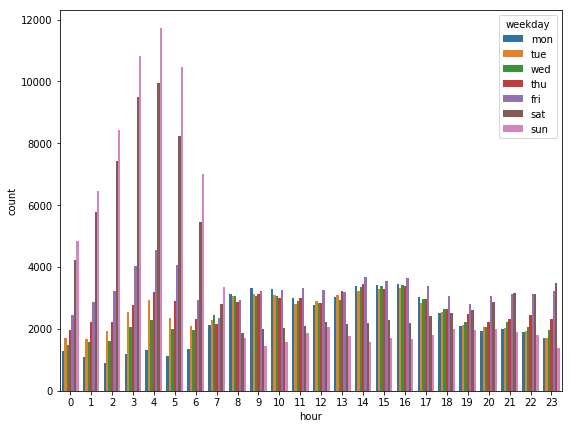

In [43]:
plt.figure(figsize=(9, 7))
sns.countplot(x="hour", hue="weekday", data=df_call_type_c)

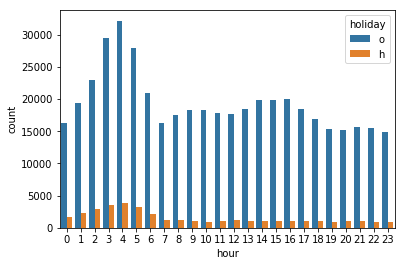

In [44]:
sns.countplot(x="hour", hue="holiday", data=df_call_type_c)

#### 考察
- タクシー乗り場の場合
    - 流しの1.5 - 2倍程利用されている
    - 平日の7-20時の利用が多い
    - 土日は0-6時の利用が多い
- 流しの場合
    - 1-6時はタクシー乗り場より利用が多い。
    - 1-6時は土日の利用が多い

### DAYTYPE考察
    (char) It identifies the daytype of the trip's start. It assumes one of three possible values:
    'A' otherwise (i.e. a normal day, workday or weekend).
    'B' if this trip started on a holiday or any other special day (i.e. extending holidays)
    'C' if the trip started on a day before a type-B day;


In [45]:
# DAY_TYPEの欠損値はなし
df["DAY_TYPE"].isnull().sum()

0

In [46]:
# 配車センターは DAY_TYPE = A（旅行以外）しかない
print(df_call_type_a[df_call_type_a["DAY_TYPE"] == "A"].shape[0])
print(df_call_type_a[df_call_type_a["DAY_TYPE"] == "B"].shape[0])
print(df_call_type_a[df_call_type_a["DAY_TYPE"] == "C"].shape[0])

# スタンドは DAY_TYPE = A（旅行以外）しかない
print(df_call_type_b[df_call_type_b["DAY_TYPE"] == "A"].shape[0])
print(df_call_type_b[df_call_type_b["DAY_TYPE"] == "B"].shape[0])
print(df_call_type_b[df_call_type_b["DAY_TYPE"] == "C"].shape[0])

# 流しは DAY_TYPE = A（旅行以外）しかない
print(df_call_type_c[df_call_type_c["DAY_TYPE"] == "A"].shape[0])
print(df_call_type_c[df_call_type_c["DAY_TYPE"] == "B"].shape[0])
print(df_call_type_c[df_call_type_c["DAY_TYPE"] == "C"].shape[0])

362716
0
0
808889
0
0
502547
0
0


In [47]:
(362716 + 808889 + 502547), df.shape[0]

(1674152, 1674152)

DAY_TYPE = Aしかないが、今回の課題には関係ないので、これ以上、考察しない。

### ORIGIN_CALL考察
    (integer) It contains a unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip's customer if CALL_TYPE='A'. Otherwise, it assumes a NULL value;

In [48]:
print(df["ORIGIN_CALL"].isnull().sum())
print(df_call_type_a.shape[0], df_call_type_a["ORIGIN_CALL"].isnull().sum())
print(df_call_type_b.shape[0], df_call_type_b["ORIGIN_CALL"].isnull().sum())
print(df_call_type_c.shape[0], df_call_type_c["ORIGIN_CALL"].isnull().sum())

1311436
362716 0
808889 808889
502547 502547


In [49]:
(362716 + 808889 + 502547), df.shape[0]

(1674152, 1674152)

顧客を特定する電話番号なので、配車センター以外は登録されていない（＝予想通り）

#### ORIGIN_STAND考察
    : (integer): It contains a unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE='B'. Otherwise, it assumes a NULL value;

In [50]:
print(df["ORIGIN_STAND"].isnull().sum())
print(df_call_type_a.shape[0], df_call_type_a["ORIGIN_STAND"].isnull().sum())
print(df_call_type_b.shape[0], df_call_type_b["ORIGIN_STAND"].isnull().sum())
print(df_call_type_c.shape[0], df_call_type_c["ORIGIN_STAND"].isnull().sum())

876466
362716 362716
808889 11203
502547 502547


スタンド以外は、全てNULL。一部のスタンドで入力がないが、使用しないので、これ以上の考察はしない。

### 使用する列の再整理＆保存

In [51]:
# 降車ポイントが不明なデータを削除
df.drop(df[df["MISSING_DATA"] != False].index.values, inplace=True)

col_names = [
    "TIMESTAMP", "year", "month", "day", "weekday", "hour", "minute",
    "holiday", "riding_time", "distance", "start_x", "start_y", "end_x",
    "end_y", "CALL_TYPE", "TAXI_ID"
]

df.sort_values(
    by=["year", "month", "day", "hour", "minute", "second"],
    ascending=True,
    inplace=True)

# 要らない列を削除
df.drop([
    "second", "TRIP_ID", "DAY_TYPE", "ORIGIN_STAND", "ORIGIN_CALL",
    "MISSING_DATA"
],
        axis=1,
        inplace=True)

# 列の並び替え
df = df.reindex(col_names, axis=1)

# 元の行インデックスをdropし、振りなおす
df.reset_index(drop=True, inplace=True)

In [52]:
df.head()

,TIMESTAMP,year,month,day,weekday,hour,minute,holiday,riding_time,distance,start_x,start_y,end_x,end_y,CALL_TYPE,TAXI_ID
0,1372636853,2013,7,1,mon,0,0,o,375,2.395003,-8.610291,41.140746,-8.605890,41.145345,C,20000380
1,1372636854,2013,7,1,mon,0,0,o,645,10.114430,-8.574678,41.151951,-8.607996,41.142915,C,20000520
2,1372636858,2013,7,1,mon,0,0,o,345,3.186095,-8.618643,41.141412,-8.630838,41.154489,C,20000589
3,1372636875,2013,7,1,mon,0,1,o,330,2.549688,-8.619894,41.148009,-8.609490,41.157351,C,20000233
4,1372636896,2013,7,1,mon,0,1,o,645,10.080812,-8.617599,41.146137,-8.636625,41.169141,C,20000360


In [53]:
df.to_csv("data/edit_train_final.csv", index=False, header=True)

## 流しのみ区画に分ける

In [54]:
# 流しは DAY_TYPE = A（旅行以外）しかない
print(df_call_type_c[df_call_type_c["DAY_TYPE"] == "A"].shape)
print(df_call_type_c[df_call_type_c["DAY_TYPE"] == "B"].shape)
print(df_call_type_c[df_call_type_c["DAY_TYPE"] == "C"].shape)

(502547, 22)
(0, 22)
(0, 22)


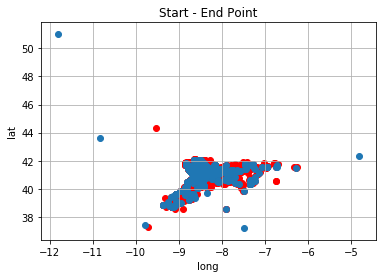

In [55]:
plt.scatter(df_call_type_c["end_x"], df_call_type_c["end_y"], color ='r')
plt.scatter(df_call_type_c["start_x"], df_call_type_c["start_y"])
plt.title("Start - End Point")
plt.xlabel("long")
plt.ylabel("lat")
plt.grid()

In [56]:
df_call_type_c.describe()[["riding_time", "distance", "start_x", "start_y", "end_x", "end_y"]]

,riding_time,distance,start_x,start_y,end_x,end_y
count,502547.000000,502547.000000,502547.000000,502547.000000,502547.000000,502547.000000
mean,826.510724,7.716674,-8.618668,41.156637,-8.620709,41.163464
std,993.778382,12.595755,0.033315,0.032558,0.045607,0.048331
min,30.000000,0.000000,-11.820645,37.184832,-9.729117,37.313784
25%,420.000000,2.890794,-8.629722,41.147163,-8.644891,41.148819
50%,630.000000,5.113712,-8.613396,41.152491,-8.615808,41.158728
75%,945.000000,9.163816,-8.606146,41.163093,-8.602839,41.173092
max,58215.000000,1335.144743,-4.816116,51.037119,-6.263919,44.351622


long = -9度 ～ -7度は距離的に222km位なので、start_xとstart_yの平均を中心（-8.618668, 41.156636)を中心に20km(= 40km,40km)に範囲を絞ってみる。  

0.01度=1.11kmなので、0.2度=22.2km
-8.61866 ±　0.2
41.156636 ±　0.2

のデータに絞る。

In [57]:
-8.61866 + 0.20, -8.61866 - 0.20, 41.156636 + 0.20, 41.156636 - 0.20

(-8.418660000000001, -8.81866, 41.356636, 40.956635999999996)

In [58]:
# df_call_type_c_plus = df_call_type_c[
#     (df_call_type_c["start_x"] >= -8.818666)
#     & (df_call_type_c["start_x"] <= -8.418660000000001)
#     & (df_call_type_c["start_y"] >= 40.956635999999996)
#     & (df_call_type_c["start_y"] <= 41.356636)]

# 上記と同じコード
df_call_type_c_plus = df_call_type_c.query(
    "-8.818666 <= start_x <= -8.418660000000001 and 40.956635999999996 <= start_y <= 41.356636"
)

df_call_type_c_plus.shape, df_call_type_c.shape, df_call_type_c_plus.shape[0] / df_call_type_c.shape[0]

((501772, 22), (502547, 22), 0.99845785568315)

99.8%が　(40,40)圏内にいる。

In [59]:
(-8.418660000000001 - (-8.818666 ))*111, (41.356636 - 40.956635999999996)* 111

(44.40066599999994, 44.40000000000063)

### 緯度、経度を10等分する

#### 境界値の算出

In [60]:
long_cut, long_bins = pd.cut(pd.Series([-8.818666, -8.418660000000001]), 10, retbins=True)

lat_cut, lat_bins = pd.cut(pd.Series([40.956635999999996, 41.356636]), 10, retbins=True)

long_bins, lat_bins

(array([-8.81906601, -8.7786654 , -8.7386648 , -8.6986642 , -8.6586636 ,
        -8.618663  , -8.5786624 , -8.5386618 , -8.4986612 , -8.4586606 ,
        -8.41866   ]),
 array([40.956236, 40.996636, 41.036636, 41.076636, 41.116636, 41.156636,
        41.196636, 41.236636, 41.276636, 41.316636, 41.356636]))

#### 分割位置列を追加

In [61]:
# お試しコード
# long_bins = [
#     -8.7786654, -8.7386648, -8.6986642, -8.6586636, -8.618663, -8.5786624,
#     -8.5386618, -8.4986612, -8.4586606, -8.41866
# ]

# lat_bins = [
#     40.996636, 41.036636, 41.076636, 41.116636, 41.156636, 41.196636,
#     41.236636, 41.276636, 41.316636, 41.356636
# ]

# for i, v in enumerate(long_bins):
#     print(i, v)

In [62]:
# area =[
#         ["area_00", "area_01", "area_02", "area_03", "area_04", "area_05", "area_06", "area_07", "area_08", "area_09" ]
#         ,["area_10", "area_11", "area_12", "area_13", "area_14", "area_15", "area_16", "area_17", "area_18", "area_19" ]
#         ,["area_20", "area_21", "area_22", "area_23", "area_24", "area_25", "area_26", "area_27", "area_28", "area_29" ]
#         ,["area_30", "area_31", "area_32", "area_33", "area_34", "area_35", "area_36", "area_37", "area_38", "area_39" ]
#         ,["area_40", "area_41", "area_42", "area_43", "area_54", "area_45", "area_46", "area_47", "area_48", "area_49" ]
#         ,["area_50", "area_51", "area_52", "area_53", "area_54", "area_55", "area_56", "area_57", "area_58", "area_59" ]
#         ,["area_60", "area_61", "area_62", "area_63", "area_64", "area_65", "area_66", "area_67", "area_68", "area_69" ]
#         ,["area_70", "area_71", "area_72", "area_73", "area_74", "area_75", "area_76", "area_77", "area_78", "area_79" ]
#         ,["area_80", "area_81", "area_82", "area_83", "area_84", "area_85", "area_86", "area_87", "area_88", "area_89" ]
#         ,["area_90", "area_91", "area_92", "area_93", "area_94", "area_95", "area_96", "area_97", "area_98", "area_99" ]
# ]
# area[0][0]

In [63]:
def split_area(row):
    
    long_bins = [
        -8.7786654, -8.7386648, -8.6986642, -8.6586636, -8.618663, -8.5786624,
        -8.5386618, -8.4986612, -8.4586606, -8.41866
    ]

    lat_bins = [
        40.996636, 41.036636, 41.076636, 41.116636, 41.156636, 41.196636,
        41.236636, 41.276636, 41.316636, 41.356636
    ]
    
    area = [
        ["area_00", "area_01", "area_02", "area_03", "area_04", "area_05", "area_06", "area_07", "area_08", "area_09" ]
        ,["area_10", "area_11", "area_12", "area_13", "area_14", "area_15", "area_16", "area_17", "area_18", "area_19" ]
        ,["area_20", "area_21", "area_22", "area_23", "area_24", "area_25", "area_26", "area_27", "area_28", "area_29" ]
        ,["area_30", "area_31", "area_32", "area_33", "area_34", "area_35", "area_36", "area_37", "area_38", "area_39" ]
        ,["area_40", "area_41", "area_42", "area_43", "area_54", "area_45", "area_46", "area_47", "area_48", "area_49" ]
        ,["area_50", "area_51", "area_52", "area_53", "area_54", "area_55", "area_56", "area_57", "area_58", "area_59" ]
        ,["area_60", "area_61", "area_62", "area_63", "area_64", "area_65", "area_66", "area_67", "area_68", "area_69" ]
        ,["area_70", "area_71", "area_72", "area_73", "area_74", "area_75", "area_76", "area_77", "area_78", "area_79" ]
        ,["area_80", "area_81", "area_82", "area_83", "area_84", "area_85", "area_86", "area_87", "area_88", "area_89" ]
        ,["area_90", "area_91", "area_92", "area_93", "area_94", "area_95", "area_96", "area_97", "area_98", "area_99" ]
    ]
    
    _start_long = row["start_x"]
    _start_lat = row["start_y"]

    for i, x in enumerate(long_bins):
        
        if _start_long < x:            
            for j, y in enumerate(lat_bins):                    
                if _start_lat < y:
                    return area[i][j]
    
    return "area_err"    

df_call_type_c_plus["area"] = df_call_type_c_plus.apply(split_area, axis=1)

In [64]:
# 要らない列を削除
df_call_type_c_plus.drop(["second", "TAXI_ID", "TRIP_ID", "DAY_TYPE", "CALL_TYPE", "ORIGIN_STAND", "ORIGIN_CALL", "MISSING_DATA"] , axis=1, inplace=True)
df_call_type_c_plus.head()

,TIMESTAMP,year,month,day,weekday,hour,minute,holiday,riding_time,distance,start_x,start_y,end_x,end_y,area
0,1372636853,2013,7,1,mon,0,0,o,375,2.395003,-8.610291,41.140746,-8.605890,41.145345,area_54
1,1372636854,2013,7,1,mon,0,0,o,645,10.114430,-8.574678,41.151951,-8.607996,41.142915,area_64
2,1372636858,2013,7,1,mon,0,0,o,345,3.186095,-8.618643,41.141412,-8.630838,41.154489,area_54
3,1372636875,2013,7,1,mon,0,1,o,330,2.549688,-8.619894,41.148009,-8.609490,41.157351,area_54
4,1372636896,2013,7,1,mon,0,1,o,645,10.080812,-8.617599,41.146137,-8.636625,41.169141,area_54


area_54 = [(-8.618663, -8.5786624), (41.116636, 41.156636)]  
area_55 = [(-8.618663, -8.5786624), (41.156636, 41.196636)]  
area_45 = [(-8.6586636, -8.618663), (41.156636, 41.196636)]  

In [65]:
0.570402 + 0.151611 + 0.137060 + 0.060816 + 0.028718

0.948607

area_54    0.570402
area_55    0.151611
area_45    0.137060
area_35    0.060816
area_34    0.028718
area_65    0.016533
area_64    0.009425
area_36    0.004570
area_37    0.004143
area_46    0.002916
area_66    0.002529
area_75    0.001660
area_56    0.001648
area_53    0.001552
area_74    0.000889
area_43    0.000777
area_76    0.000670
area_47    0.000662
area_26    0.000574
area_41    0.000357
area_57    0.000265
area_63    0.000243
area_85    0.000233
area_25    0.000229
area_42    0.000175
area_52    0.000173
area_73    0.000132
area_67    0.000114
area_95    0.000092
area_28    0.000076
             ...   
area_77    0.000032
area_60    0.000030
area_79    0.000022
area_38    0.000020
area_40    0.000018
area_69    0.000016
area_50    0.000016
area_86    0.000016
area_89    0.000016
area_51    0.000016
area_68    0.000016
area_70    0.000016
area_83    0.000014
area_58    0.000014
area_87    0.000012
area_96    0.000010
area_88    0.000008
area_48    0.000008
area_78    0.000008


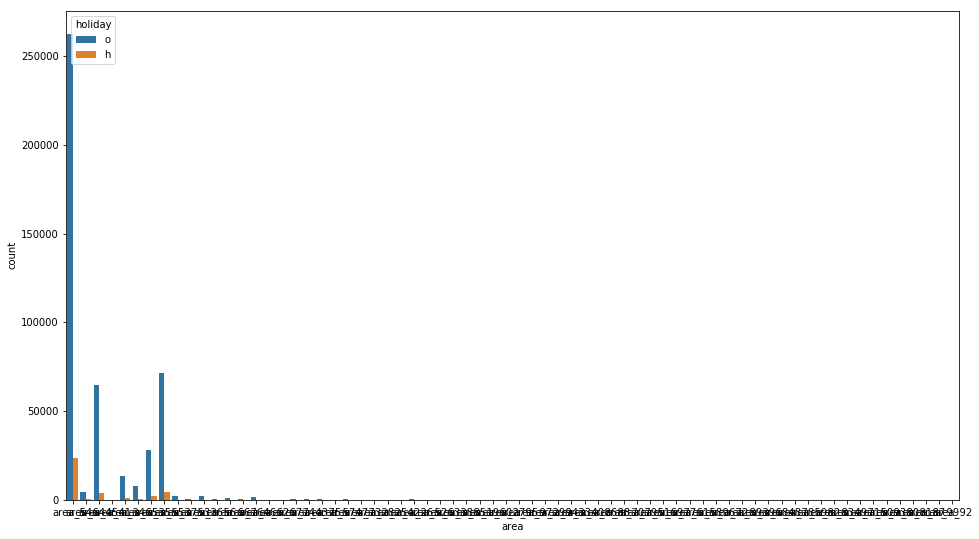

In [66]:
plt.figure(figsize=(16, 9))
sns.countplot(x="area", hue="holiday", data=df_call_type_c_plus)

# 確率
display((df_call_type_c_plus["area"].value_counts() / df_call_type_c_plus.shape[0]))

時間毎に集計すれば乗車実績ベースの確率はでるが、データ編集しただけでつまらない・・・    
TODO:ヒートマップみたいにエリア毎に、確立を図示するには？

### 1時間を4分割

15毎に分析する為、00、15,30,45分に補正

In [67]:
def convert_min(x):
    if x < 15:
        return 0
    elif 15 <= x < 30:
        return 15
    elif 30 <= x < 45:
        return 30
    elif 45 <= x:
        return 45
    else:
        return np.Inf

df_call_type_c_plus["minute"] = df_call_type_c_plus["minute"].apply(convert_min)

### 降車方向を追加

緯度に対する角度で分割  


    

In [68]:
print("### E:{} - {}度".format(360 - 22.5, -22.5 + 45))
print("### NE:{} - {}度".format(22.5, 22.5 + 45))
print("### N:{} - {}度".format(67.5, 67.5 + 45))
print("### NW:{} - {}度".format(112.5, 112.5 + 45))
print("### W:{} - {}度".format(157.5, 157.5 + 45))
print("### SW:{} - {}度".format(202.5, 202.5 + 45))
print("### S:{} - {}度".format(247.5, 247.5 + 45))
print("### SE:{} - {}度".format(292.5, 292.5 + 45))

### E:337.5 - 22.5度
### NE:22.5 - 67.5度
### N:67.5 - 112.5度
### NW:112.5 - 157.5度
### W:157.5 - 202.5度
### SW:202.5 - 247.5度
### S:247.5 - 292.5度
### SE:292.5 - 337.5度


In [69]:
_v1 = np.array([1.0, 0.0])
_v2 = np.array([-8.605890 - -8.610291, 41.145345 - 41.140746])

print(_v1, _v2)

_cos = np.dot(_v1, _v2)/(np.linalg.norm(_v1) * np.linalg.norm(_v2))

np.rad2deg(np.arccos(_cos))

[1. 0.] [0.004401 0.004599]


46.26030384649905

In [70]:
def get_direction(row):

    _start_x = row["start_x"]
    _start_y = row["start_y"]

    _end_x = row["end_x"]
    _end_y = row["end_y"]

    # 原点を start_x、start_y に移動
    _v1 = np.array([1.0, 0.0])
    _v2 = np.array([_end_x - _start_x, _end_y - _start_y])

    # コサインを算出
    _cosine = np.dot(_v1, _v2) / np.linalg.norm(_v2)

    # 角度をラジアンから度に変換
    _degree = np.rad2deg(np.arccos(_cosine))

    if _degree > 337.5 or _degree <= 22.5:
        return "E"
    elif _degree > 22.5 or _degree <= 67.5:
        return "NE"
    elif _degree > 67.5 or _degree <= 112.5:
        return "N"
    elif _degree > 112.5 or _degree <= 157.5:
        return "NW"
    elif _degree > 157.5 or _degree <= 202.5:
        return "W"
    elif _degree > 202.5 or _degree <= 247.5:
        return "SW"
    elif _degree > 247.5 or _degree <= 292.5:
        return "S"
    elif _degree > 292.5 or _degree <= 337.5:
        return "SE"

    return "UN"


df_call_type_c_plus["direction"] = df_call_type_c_plus.apply(get_direction, axis=1)

In [71]:
df_call_type_c_plus.head()

,TIMESTAMP,year,month,day,weekday,hour,minute,holiday,riding_time,distance,start_x,start_y,end_x,end_y,area,direction
0,1372636853,2013,7,1,mon,0,0,o,375,2.395003,-8.610291,41.140746,-8.605890,41.145345,area_54,NE
1,1372636854,2013,7,1,mon,0,0,o,645,10.114430,-8.574678,41.151951,-8.607996,41.142915,area_64,NE
2,1372636858,2013,7,1,mon,0,0,o,345,3.186095,-8.618643,41.141412,-8.630838,41.154489,area_54,NE
3,1372636875,2013,7,1,mon,0,0,o,330,2.549688,-8.619894,41.148009,-8.609490,41.157351,area_54,NE
4,1372636896,2013,7,1,mon,0,0,o,645,10.080812,-8.617599,41.146137,-8.636625,41.169141,area_54,NE


In [72]:
# 乗降ポイントが同じ乗車履歴が UN になっている
df_call_type_c_plus[df_call_type_c_plus["direction"] == "UN"].head()

,TIMESTAMP,year,month,day,weekday,hour,minute,holiday,riding_time,distance,start_x,start_y,end_x,end_y,area,direction
3721,1372700647,2013,7,1,mon,17,30,o,30,0.0,-8.629047,41.169843,-8.629047,41.169843,area_45,UN
3978,1372705456,2013,7,1,mon,19,0,o,30,0.0,-8.624583,41.136984,-8.624583,41.136984,area_54,UN
21043,1373022718,2013,7,5,fri,11,0,o,30,0.0,-8.636085,41.164254,-8.636085,41.164254,area_45,UN
42945,1373399077,2013,7,9,tue,19,30,o,45,0.0,-8.585955,41.148477,-8.585955,41.148477,area_54,UN
51654,1373557186,2013,7,11,thu,15,30,o,30,0.0,-8.689293,41.168205,-8.689293,41.168205,area_35,UN


### area_54で乗車した際の進行方向

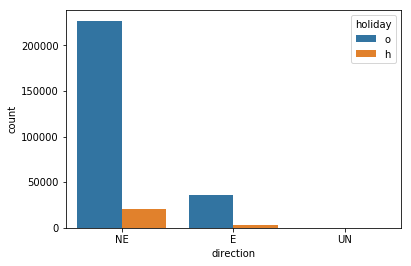

In [73]:
sns.countplot(x="direction", hue="holiday", data=df_call_type_c_plus.query("area == 'area_54'"))

### ここまでのデータを保存

In [74]:
df_call_type_c_plus.to_csv("data/edit_train_call_type_c.csv", index=False, header=True)

## 分析方針

１.全ドライバーの移動距離と乗車時間と乗車回数の合計を算出  
２.乗車時間と乗車回数の２軸でプロット  
３.クラスタリング  
４.  

乗車時間／乗車回数　で優良ドライバーを特定


タクシーの料金は、初乗り運賃の時点から「距離」と「時間」を併用。

タクシーの料金は基本的に一定距離内の初乗り運賃（例：東京：最長1.052kmまで、上限410円）
を越えて乗車した場合の走行距離に応じた「距離制」で計算されるが、走行速度が10km/h以下になった場合には、走行時間を距離に置き換えて計算する「時間距離併用制」が適用される。


## 乗車率の算出

### 乗車率の定義
1日の乗車時間（秒）/ 24 * 60 * 60(秒）    

※日跨ぎで働くドライバーでも1日の稼働時間は同じという前提。   
例）9-18（8h）、22-25(1h）＋ 10-15(5h）＋22-25(2h）　


In [75]:
def calc_working_rate(arr: np.ndarray):
    
    # 24 * 60 * 60 = 86400
    return ( arr.sum() / 86400) * 100

In [76]:
24 * 60 * 60

86400